# Coding for Economists - Session 8

***

## 1. Setup Environment

In [10]:
%pip install networkx torch torch_geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install econml

  Installing build dependencies .done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 14.6 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.2/26.2 MB 23.0 MB/s eta 0:00:00a 0:00:01
  Created wheel for shap: filename=shap-0.43.0-cp312-cp312-macosx_11_0_arm64.whl size=442894 sha256=1ca99dfe2dd9d9c10ea99e199774f9c8c449043399d85612978f1f3b34521f2b
  Stored in directory: /Users/jiancao/Library/Caches/pip/wheels/e0/cb/3e/46cb0f77e2e4f5aa9fd5d399dedb3ba84f91f0c49e3db7d0e1
Successfully built shap
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully unin

In [25]:
%pip install --upgrade jupyter ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 17.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Turn on copy on write
pd.options.mode.copy_on_write = True

## 2. K-Means Clustering

### 2.1 Read Data

In [2]:
# Load the publicly available macroeconomic dataset
import statsmodels.api as sm
data = sm.datasets.macrodata.load_pandas().data

# Select a subset of economic indicators for clustering
# Here we use real GDP, inflation, and unemployment
df = data[['realgdp', 'infl', 'unemp']]
df.head()

,realgdp,infl,unemp
0,2710.349,0.00,5.8
1,2778.801,2.34,5.1
2,2775.488,2.74,5.3
3,2785.204,0.27,5.6
4,2847.699,2.31,5.2


### 2.2 Preprocessing

In [3]:
# Scale the data (important for clustering)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

### 2.3 Determine the Optimal Number of Clusters

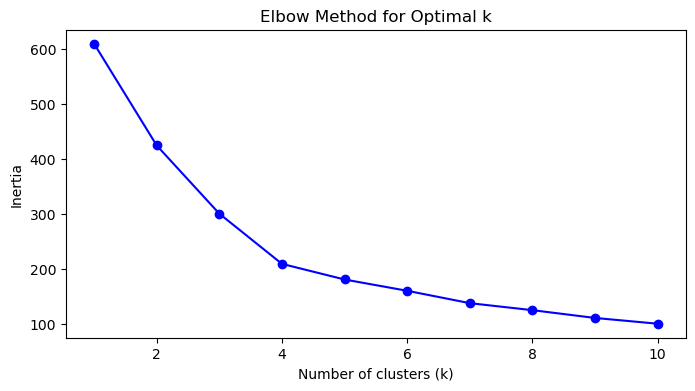

In [4]:
# Determine the optimal number of clusters using the elbow method
from sklearn.cluster import KMeans
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=1234)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve (within cluster sum of squares)
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

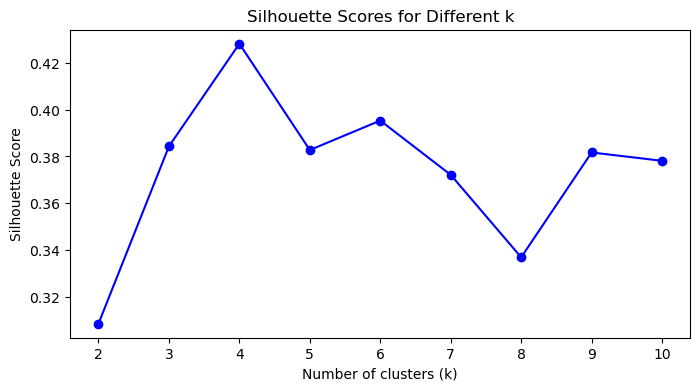

In [5]:
# Determine optimal k using silhouette scores (requires k>=2)
from sklearn.metrics import silhouette_score
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_data)
    score = silhouette_score(scaled_data, labels)
    silhouette_scores.append(score)

# Plot the silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), silhouette_scores, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k')
plt.show()

In [6]:
# Based on the elbow and silhouette methods, choose an optimal k
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

### 2.4 Visualize the Clusters

In [7]:
# Add cluster labels to the dataframe
df['cluster'] = clusters

# Use PCA to reduce dimensions to 2 for visualization purposes
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=1234)
pca_result = pca.fit_transform(scaled_data)
df['pca1'] = pca_result[:, 0]
df['pca2'] = pca_result[:, 1]
df.head()

,realgdp,infl,unemp,cluster,pca1,pca2
0,2710.349,0.00,5.8,2,0.099548,-0.108539
1,2778.801,2.34,5.1,2,0.380380,-0.737446
2,2775.488,2.74,5.3,2,0.513089,-0.642221
3,2785.204,0.27,5.6,2,0.087804,-0.251655
4,2847.699,2.31,5.2,2,0.385749,-0.665538


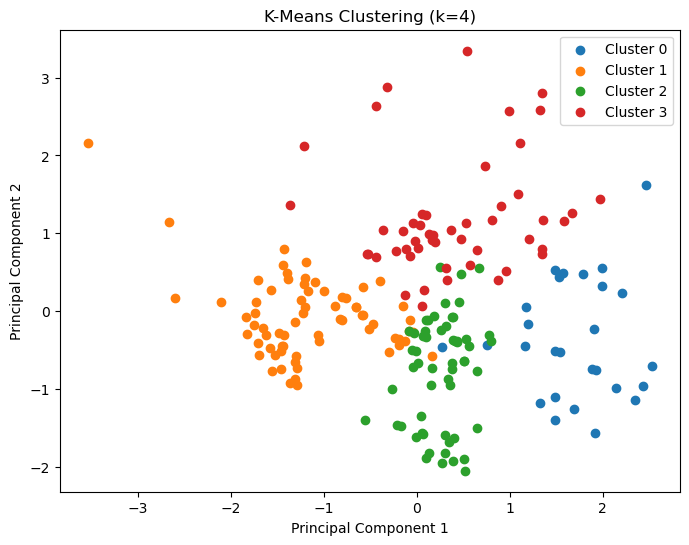

In [8]:
# Plot the clusters in the PCA-reduced space
plt.figure(figsize=(8, 6))
for cluster in range(optimal_k):
    subset = df[df['cluster'] == cluster]
    plt.scatter(subset['pca1'], subset['pca2'], label=f'Cluster {cluster}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title(f'K-Means Clustering (k={optimal_k})')
plt.legend()
plt.show()

## 3. Policy Evaluation: Causal Forest

### 3.1 Read Data

In [9]:
df = pd.read_csv('lalonde_data.csv', index_col=0)
print(df.shape)
df.head()

(614, 10)


,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
ID,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


- __treat__: 1 participated in job training program, 0 otherwise
- __age__: measured in years;
- __educ__: measured in years;
- __black__: indicating race (1 if black, 0 otherwise);
- __hispan__: indicating race (1 if Hispanic, 0 otherwise);
- __married__: indicating marital status (1 if married, 0 otherwise);
- __nodegree__: indicating high school diploma (1 if no degree, 0 otherwise);
- __re74__: real earnings in 1974;
- __re75__: real earnings in 1975;
- __re78__: real earnings in 1978.

In [10]:
df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


### 3.2 Data Cleaning

In [11]:
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 treat       0
age         0
educ        0
black       0
hispan      0
married     0
nodegree    0
re74        0
re75        0
re78        0
dtype: int64


### 3.3 Preprocessing

In [12]:
df.dtypes

treat         int64
age           int64
educ          int64
black         int64
hispan        int64
married       int64
nodegree      int64
re74        float64
re75        float64
re78        float64
dtype: object

### 3.4 Prepare Train/Test Sets

In [13]:
# Define outcome (Y), treatment (T), and covariates (X)
Y = df['re78'].values       # outcome variable: earnings in 1978
T = df['treat'].values      # treatment indicator
# Use remaining columns as covariates
X = df.drop(columns=['treat', 're78']).values

# Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(
    X, Y, T, test_size=0.2, random_state=1234
)

### 3.5 Implement Causal Forest and Tune Parameters

#### Define Hyperparameter Grid for Tuning
- __n_estimators__: The number of trees in the forest.
- __max_depth__: The maximum depth of the tree.
- __min_samples_split__: The minimum number of samples required to split an internal node.
- __max_features__: The number of features to consider when looking for the best split.

In [28]:
param_grid = {
    'n_estimators': [300, 500],
    'max_depth': [3, 5,],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

best_model = None
best_params = None
best_cate_std = np.inf

#### Grid Search

In [29]:
from sklearn.model_selection import ParameterGrid
from econml.dml import CausalForestDML
# For causal inference, one approach is to choose the hyperparameters that provide stable (low-variance) CATE estimates.
# Here, as a demo, we use the standard deviation of the estimated Conditional Average Treatment Effects (CATE)
# on the test set as a proxy (lower variance can indicate more stable estimates).

for params in ParameterGrid(param_grid):
    model = CausalForestDML(
        model_y='forest',
        model_t='forest',
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split'],
        max_features=params['max_features'],
        random_state=1234,
        verbose=0
    )
    model.fit(Y_train, T_train, X=X_train)
    # Estimate the CATE on the test set
    cate_test = model.effect(X_test)
    cate_std = np.std(cate_test)
    print(f"Params: {params}, CATE std: {cate_std:.2f}")
    
    if cate_std < best_cate_std:
        best_cate_std = cate_std
        best_params = params
        best_model = model

print("\nBest Hyperparameters:", best_params)

Params: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}, CATE std: 1035.37
Params: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 500}, CATE std: 949.39
Params: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 300}, CATE std: 1035.37
Params: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 500}, CATE std: 949.39
Params: {'max_depth': 3, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 300}, CATE std: 1093.53
Params: {'max_depth': 3, 'max_features': 'log2', 'min_samples_split': 2, 'n_estimators': 500}, CATE std: 1037.07
Params: {'max_depth': 3, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 300}, CATE std: 1093.53
Params: {'max_depth': 3, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 500}, CATE std: 1037.07
Params: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 300}, CAT

### 3.6 Validate the Model

In [24]:
# Estimate the Average Treatment Effect (ATE) and its confidence interval on the test set.
ate_point = best_model.ate(X_test)
ate_lb, ate_ub = best_model.ate_interval(X_test, alpha=0.05)
print(f"\nEstimated ATE: {ate_point:.2f}")
print(f"95% Confidence Interval for ATE: ({ate_lb:.2f}, {ate_ub:.2f})")

# Also, compute CATE for each test observation
cate_pred = best_model.effect(X_test)


Estimated ATE: 451.52
95% Confidence Interval for ATE: (-1932.90, 2835.93)


### 3.7 Visualization

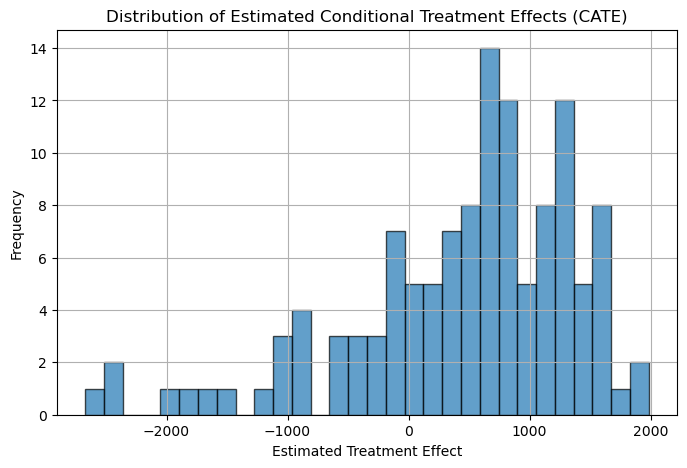

In [25]:
# Plot 1: Histogram of Estimated CATE
plt.figure(figsize=(8, 5))
plt.hist(cate_pred, bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribution of Estimated Conditional Treatment Effects (CATE)")
plt.xlabel("Estimated Treatment Effect")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

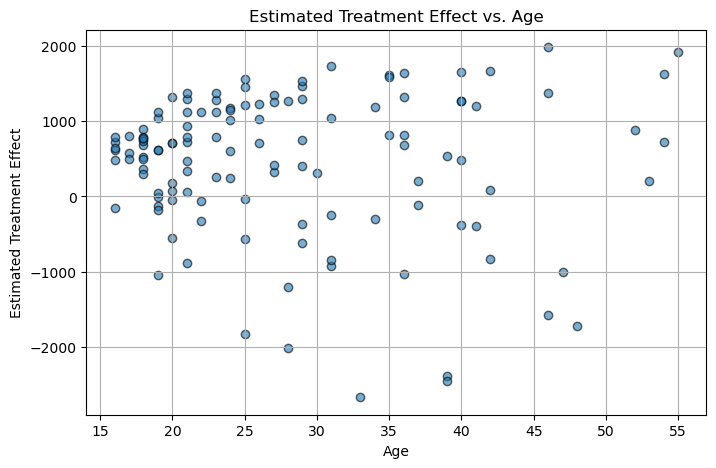

In [26]:
# Plot 2: Scatter Plot of CATE vs. a Covariate (e.g., Age)
# Assuming the first column in X corresponds to age
age_test = X_test[:, 0]
plt.figure(figsize=(8, 5))
plt.scatter(age_test, cate_pred, alpha=0.6, edgecolor='k')
plt.title("Estimated Treatment Effect vs. Age")
plt.xlabel("Age")
plt.ylabel("Estimated Treatment Effect")
plt.grid(True)
plt.show()

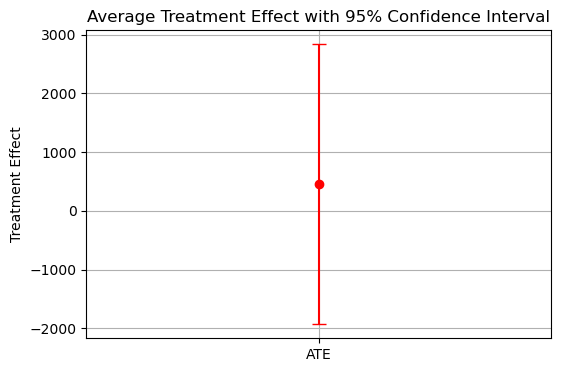

In [27]:
# Plot 3: Visualize the ATE with its Confidence Interval
plt.figure(figsize=(6, 4))
plt.errorbar(1, ate_point, yerr=[[ate_point - ate_lb], [ate_ub - ate_point]], fmt='o', color='red', capsize=5)
plt.xlim(0.5, 1.5)
plt.xticks([1], ['ATE'])
plt.title("Average Treatment Effect with 95% Confidence Interval")
plt.ylabel("Treatment Effect")
plt.grid(True)
plt.show()

In [ ]:
# Comprehensive Causal Forest Pipeline for Policy Evaluation
# (Example uses the LaLonde dataset for evaluating job training program effects)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split, ParameterGrid
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# 1. Read Online Data
# -------------------------------
# (Replace the URL with your dataset URL)
url = "https://raw.githubusercontent.com/scunning1975/causal-inference-class/master/la_lalonde.csv"
data = pd.read_csv(url)

# -------------------------------
# 2. Data Cleaning and Preprocessing
# -------------------------------
# Inspect the data and drop rows with missing values (if any)
print("Data shape before cleaning:", data.shape)
data = data.dropna()
print("Data shape after cleaning:", data.shape)

# For demonstration, we assume:
# - 'treat' is the treatment indicator (1 if treated, 0 otherwise)
# - 're78' is the outcome (e.g., earnings in 1978)
# - Other columns (e.g., age, education, race, marital status, etc.) are covariates

# For simplicity, select a subset of relevant columns:
cols = ['treat', 're78', 'age', 'educ', 'race', 'married', 'nodegree', 're74', 're75']
data = data[cols]

# Convert categorical variables if needed:
# (For instance, convert 'race' and 'married' to numeric dummy variables)
data = pd.get_dummies(data, columns=['race', 'married'], drop_first=True)

# -------------------------------
# 3. Prepare Data for Causal Forest
# -------------------------------
# Define outcome (Y), treatment (T), and covariates (X)
Y = data['re78'].values       # outcome variable: earnings in 1978
T = data['treat'].values      # treatment indicator
# Use remaining columns as covariates
X = data.drop(columns=['treat', 're78']).values

# Split into training and testing sets
X_train, X_test, Y_train, Y_test, T_train, T_test = train_test_split(
    X, Y, T, test_size=0.3, random_state=123
)

# -------------------------------
# 4. Implement Causal Forest and Tune Parameters
# -------------------------------
# Here, we use EconML's CausalForestDML with RandomForest as the base learner
# For demonstration, we perform a simple grid search over two hyperparameters:
#   - n_estimators (number of trees in the forest)
#   - min_samples_leaf (minimum samples per leaf in base learners)

param_grid = {
    'n_estimators': [300, 500],
    'min_samples_leaf': [5, 10]
}

best_model = None
best_params = None
# For causal inference, one approach is to choose the hyperparameters that provide stable (low-variance) CATE estimates.
# Here, as a demo, we use the standard deviation of the estimated Conditional Average Treatment Effects (CATE)
# on the test set as a proxy (lower variance can indicate more stable estimates).
best_cate_std = np.inf

for params in ParameterGrid(param_grid):
    model = CausalForestDML(
        model_y=RandomForestRegressor(n_estimators=100, min_samples_leaf=params['min_samples_leaf'], random_state=123),
        model_t=RandomForestClassifier(n_estimators=100, min_samples_leaf=params['min_samples_leaf'], random_state=123),
        n_estimators=params['n_estimators'],
        min_samples_leaf=params['min_samples_leaf'],
        random_state=123,
        verbose=0
    )
    model.fit(Y_train, T_train, X=X_train)
    # Estimate the CATE on the test set
    cate_test = model.effect(X_test)
    cate_std = np.std(cate_test)
    print(f"Params: {params}, CATE std: {cate_std:.2f}")
    
    if cate_std < best_cate_std:
        best_cate_std = cate_std
        best_params = params
        best_model = model

print("\nBest Hyperparameters:", best_params)

# -------------------------------
# 5. Validate the Model
# -------------------------------
# Estimate the Average Treatment Effect (ATE) and its confidence interval on the test set.
ate_point = best_model.ate(X_test)
ate_lb, ate_ub = best_model.ate_interval(X_test, alpha=0.05)
print(f"\nEstimated ATE: {ate_point:.2f}")
print(f"95% Confidence Interval for ATE: ({ate_lb:.2f}, {ate_ub:.2f})")

# Also, compute CATE for each test observation
cate_pred = best_model.effect(X_test)

# -------------------------------
# 6. Show and Visualize the Results
# -------------------------------
# Plot 1: Histogram of Estimated CATE
plt.figure(figsize=(8, 5))
plt.hist(cate_pred, bins=30, edgecolor='k', alpha=0.7)
plt.title("Distribution of Estimated Conditional Treatment Effects (CATE)")
plt.xlabel("Estimated Treatment Effect")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Plot 2: Scatter Plot of CATE vs. a Covariate (e.g., Age)
# Assuming the first column in X corresponds to age
age_test = X_test[:, 0]
plt.figure(figsize=(8, 5))
plt.scatter(age_test, cate_pred, alpha=0.6, edgecolor='k')
plt.title("Estimated Treatment Effect vs. Age")
plt.xlabel("Age")
plt.ylabel("Estimated Treatment Effect")
plt.grid(True)
plt.show()

# Plot 3: Visualize the ATE with its Confidence Interval
plt.figure(figsize=(6, 4))
plt.errorbar(1, ate_point, yerr=[[ate_point - ate_lb], [ate_ub - ate_point]], fmt='o', color='red', capsize=5)
plt.xlim(0.5, 1.5)
plt.xticks([1], ['ATE'])
plt.title("Average Treatment Effect with 95% Confidence Interval")
plt.ylabel("Treatment Effect")
plt.grid(True)
plt.show()


In [11]:
import pandas as pd
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [12]:
# Here we use a publicly available country codes dataset.
# We'll use it as a basis to construct a synthetic economic network.
url = "https://raw.githubusercontent.com/datasets/country-codes/master/data/country-codes.csv"
df = pd.read_csv(url)
print("Original dataset shape:", df.shape)

# For simplicity, we select a subset of countries (and drop missing values)
df = df.dropna(subset=['official_name_en'])
df = df.reset_index(drop=True)
print("After cleaning:", df.shape)

Original dataset shape: (249, 56)
After cleaning: (249, 56)


In [13]:
np.random.seed(1234)
regions = ['Africa', 'Americas', 'Asia', 'Europe', 'Oceania']
df['region'] = np.random.choice(regions, size=len(df))
df['gdp_per_capita'] = np.random.uniform(1000, 50000, size=len(df))
threshold = 20000
df['high_income'] = (df['gdp_per_capita'] > threshold).astype(int)
df['econ_complexity'] = np.random.normal(loc=0, scale=1, size=len(df))
df.head()

,FIFA,Dial,ISO3166-1-Alpha-3,MARC,is_independent,ISO3166-1-numeric,GAUL,FIPS,WMO,ISO3166-1-Alpha-2,...,TLD,Languages,Geoname ID,CLDR display name,EDGAR,wikidata_id,region,gdp_per_capita,high_income,econ_complexity
0,AFG,93,AFG,af,Yes,4,1.0,AF,AF,AF,...,.af,"fa-AF,ps,uz-AF,tk",1149361,Afghanistan,B2,https://www.wikidata.org/wiki/Q889,Europe,47649.584181,1,0.039911
1,ALD,358,ALA,,Part of FI,248,1242.0,,,AX,...,.ax,sv-AX,661882,Kepulauan Aland,NaN,https://www.wikidata.org/wiki/Q5689,Oceania,11506.535243,0,-0.270138
2,ALB,355,ALB,aa,Yes,8,3.0,AL,AB,AL,...,.al,"sq,el",783754,Albania,B3,https://www.wikidata.org/wiki/Q222,Oceania,45336.049111,1,1.115044
3,ALG,213,DZA,ae,Yes,12,4.0,AG,AL,DZ,...,.dz,ar-DZ,2589581,Algeria,B4,https://www.wikidata.org/wiki/Q262,Africa,26901.105437,1,0.969404
4,ASA,1-684,ASM,as,Territory of US,16,5.0,AQ,,AS,...,.as,"en-AS,sm,to",5880801,Samoa Amerika,B5,https://www.wikidata.org/wiki/Q16641,Americas,38119.886436,1,-0.781151


In [20]:
# -------------------------------
# 3. Prepare Node Features and Target
# -------------------------------
# Use one-hot encoding for the region and include the econ_complexity as a feature.
region_dummies = pd.get_dummies(df['region'])
features = pd.concat([region_dummies, df[['econ_complexity']]], axis=1)
features = features.astype(float)

# Convert features and target into torch tensors.
X = torch.tensor(features.values, dtype=torch.float)
y = torch.tensor(df['high_income'].values, dtype=torch.long)

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

Feature matrix shape: torch.Size([249, 6])
Target vector shape: torch.Size([249])


In [21]:
# -------------------------------
# 4. Construct the Economic Network Graph
# -------------------------------
# We'll build a graph where nodes represent countries.
# For edges, we:
#   - Connect all countries within the same region (complete subgraph for each region)
#   - Add a few random inter-region edges to simulate global interactions.

G = nx.Graph()
num_nodes = X.shape[0]
G.add_nodes_from(range(num_nodes))

# Connect nodes within the same region (using the 'region' column)
for region in regions:
    indices = df.index[df['region'] == region].tolist()
    for i in indices:
        for j in indices:
            if i < j:
                G.add_edge(i, j)

# Add random inter-region edges (e.g., 10% of total nodes as extra random edges)
num_random_edges = int(0.1 * num_nodes)
all_nodes = list(range(num_nodes))
for _ in range(num_random_edges):
    i, j = np.random.choice(all_nodes, size=2, replace=False)
    if not G.has_edge(i, j):
        G.add_edge(i, j)

# Convert the NetworkX graph to PyTorch Geometric format (edge_index)
edge_index = torch.tensor(list(G.edges)).t().contiguous()
# Ensure the graph is undirected by adding reverse edges
edge_index = torch.cat([edge_index, edge_index[[1, 0]]], dim=1)
print("Edge index shape:", edge_index.shape)


Edge index shape: torch.Size([2, 12558])


In [22]:
# -------------------------------
# 5. Create PyTorch Geometric Data Object and Masks
# -------------------------------
data = Data(x=X, edge_index=edge_index, y=y)

# Create train/test masks for node classification (70% train, 30% test)
num_nodes = data.num_nodes
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
indices = np.arange(num_nodes)
np.random.shuffle(indices)
split = int(0.7 * num_nodes)
train_indices = indices[:split]
test_indices = indices[split:]
train_mask[train_indices] = True
test_mask[test_indices] = True
data.train_mask = train_mask
data.test_mask = test_mask

print("Train nodes:", train_mask.sum().item(), "Test nodes:", test_mask.sum().item())


Train nodes: 174 Test nodes: 75


In [23]:
# -------------------------------
# 6. Define the Graph Neural Network Model (GCN)
# -------------------------------
class GCN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

In [24]:
# -------------------------------
# 7. Train and Tune the GNN Model
# -------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
num_features = data.num_features
num_classes = 2

# Hyperparameter grid search over hidden dimensions and learning rates.
hidden_dims = [16, 32]
lrs = [0.01, 0.001]
best_acc = 0
best_params = None
best_model = None

for hidden_dim in hidden_dims:
    for lr in lrs:
        model = GCN(num_features, hidden_dim, num_classes).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
        criterion = nn.CrossEntropyLoss()
        
        num_epochs = 200
        losses = []
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            logits = model(data)
            preds = logits.argmax(dim=1)
            acc = (preds[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
        print(f"Hidden_dim: {hidden_dim}, lr: {lr}, Test Accuracy: {acc:.4f}")
        
        if acc > best_acc:
            best_acc = acc
            best_params = (hidden_dim, lr)
            best_model = model
            best_losses = losses.copy()

print("\nBest Hyperparameters (hidden_dim, lr):", best_params)
print("Best Test Accuracy:", best_acc)


Hidden_dim: 16, lr: 0.01, Test Accuracy: 0.6000
Hidden_dim: 16, lr: 0.001, Test Accuracy: 0.6000
Hidden_dim: 32, lr: 0.01, Test Accuracy: 0.6000
Hidden_dim: 32, lr: 0.001, Test Accuracy: 0.6133

Best Hyperparameters (hidden_dim, lr): (32, 0.001)
Best Test Accuracy: 0.6133333333333333


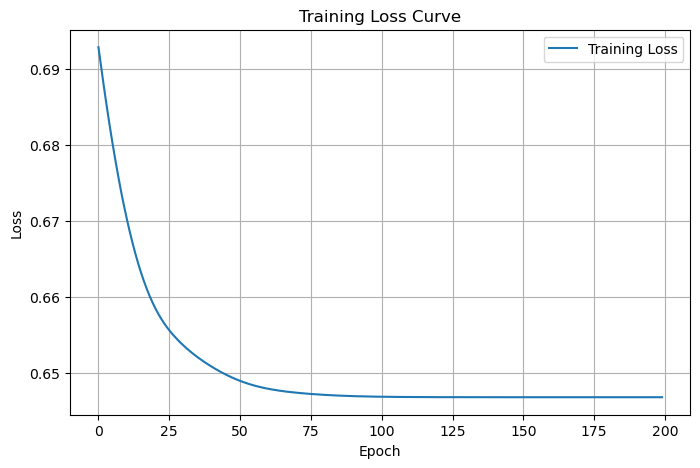

Final Test Accuracy: 0.6133333333333333


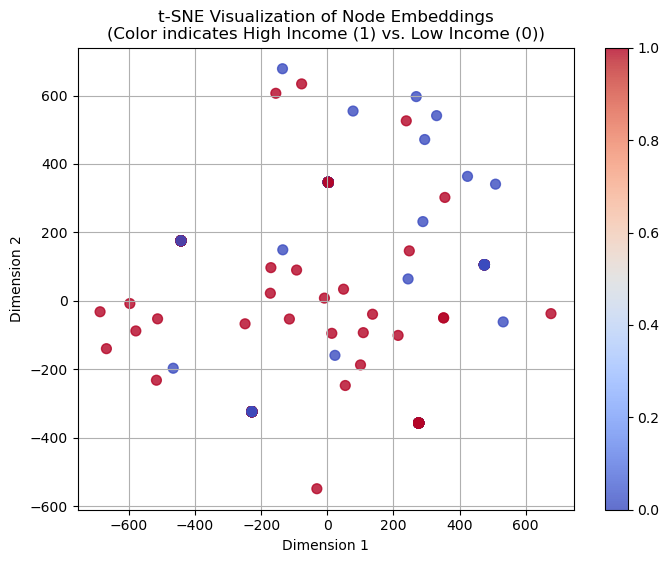

In [25]:
# -------------------------------
# 8. Validate the Model and Visualize Results
# -------------------------------
# a) Plot training loss curve
plt.figure(figsize=(8, 5))
plt.plot(best_losses, label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# b) Evaluate classification performance on test set
best_model.eval()
with torch.no_grad():
    logits = best_model(data)
    preds = logits.argmax(dim=1)
    test_acc = (preds[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
print("Final Test Accuracy:", test_acc)

# c) Visualize learned node embeddings using t-SNE
# We'll use the output of the second convolution layer (logits) as embeddings.
with torch.no_grad():
    embeddings = logits.cpu().numpy()
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
            c=data.y.cpu().numpy(), cmap='coolwarm', s=50, alpha=0.8)
plt.title("t-SNE Visualization of Node Embeddings\n(Color indicates High Income (1) vs. Low Income (0))")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar()
plt.grid(True)
plt.show()


In [ ]:
# Comprehensive GNN Pipeline for Economic Network Analysis

import pandas as pd
import numpy as np
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# -------------------------------
# 1. Read Online Economics Data
# -------------------------------
# Here we use a publicly available country codes dataset.
# We'll use it as a basis to construct a synthetic economic network.
url = "https://raw.githubusercontent.com/datasets/country-codes/master/data/country-codes.csv"
df = pd.read_csv(url)
print("Original dataset shape:", df.shape)

# For simplicity, we select a subset of countries (and drop missing values)
df = df.dropna(subset=['official_name_en'])
df = df.reset_index(drop=True)
print("After cleaning:", df.shape)

# -------------------------------
# 2. Create Synthetic Economic Features
# -------------------------------
# We will simulate a few economic attributes:
#   - region: assign each country randomly to a region
#   - gdp_per_capita: a synthetic GDP per capita (for demonstration)
#   - high_income: a binary label (1 if GDP per capita > threshold, else 0)
#   - econ_complexity: a synthetic continuous feature

np.random.seed(42)
regions = ['Africa', 'Americas', 'Asia', 'Europe', 'Oceania']
df['region'] = np.random.choice(regions, size=len(df))
df['gdp_per_capita'] = np.random.uniform(1000, 50000, size=len(df))
threshold = 20000
df['high_income'] = (df['gdp_per_capita'] > threshold).astype(int)
df['econ_complexity'] = np.random.normal(loc=0, scale=1, size=len(df))

# -------------------------------
# 3. Prepare Node Features and Target
# -------------------------------
# Use one-hot encoding for the region and include the econ_complexity as a feature.
region_dummies = pd.get_dummies(df['region'])
features = pd.concat([region_dummies, df[['econ_complexity']]], axis=1)

# Convert features and target into torch tensors.
X = torch.tensor(features.values, dtype=torch.float)
y = torch.tensor(df['high_income'].values, dtype=torch.long)

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

# -------------------------------
# 4. Construct the Economic Network Graph
# -------------------------------
# We'll build a graph where nodes represent countries.
# For edges, we:
#   - Connect all countries within the same region (complete subgraph for each region)
#   - Add a few random inter-region edges to simulate global interactions.

G = nx.Graph()
num_nodes = X.shape[0]
G.add_nodes_from(range(num_nodes))

# Connect nodes within the same region (using the 'region' column)
for region in regions:
    indices = df.index[df['region'] == region].tolist()
    for i in indices:
        for j in indices:
            if i < j:
                G.add_edge(i, j)

# Add random inter-region edges (e.g., 10% of total nodes as extra random edges)
num_random_edges = int(0.1 * num_nodes)
all_nodes = list(range(num_nodes))
for _ in range(num_random_edges):
    i, j = np.random.choice(all_nodes, size=2, replace=False)
    if not G.has_edge(i, j):
        G.add_edge(i, j)

# Convert the NetworkX graph to PyTorch Geometric format (edge_index)
edge_index = torch.tensor(list(G.edges)).t().contiguous()
# Ensure the graph is undirected by adding reverse edges
edge_index = torch.cat([edge_index, edge_index[[1, 0]]], dim=1)
print("Edge index shape:", edge_index.shape)

# -------------------------------
# 5. Create PyTorch Geometric Data Object and Masks
# -------------------------------
data = Data(x=X, edge_index=edge_index, y=y)

# Create train/test masks for node classification (70% train, 30% test)
num_nodes = data.num_nodes
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
indices = np.arange(num_nodes)
np.random.shuffle(indices)
split = int(0.7 * num_nodes)
train_indices = indices[:split]
test_indices = indices[split:]
train_mask[train_indices] = True
test_mask[test_indices] = True
data.train_mask = train_mask
data.test_mask = test_mask

print("Train nodes:", train_mask.sum().item(), "Test nodes:", test_mask.sum().item())

# -------------------------------
# 6. Define the Graph Neural Network Model (GCN)
# -------------------------------
class GCN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# -------------------------------
# 7. Train and Tune the GNN Model
# -------------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
num_features = data.num_features
num_classes = 2

# Hyperparameter grid search over hidden dimensions and learning rates.
hidden_dims = [16, 32]
lrs = [0.01, 0.001]
best_acc = 0
best_params = None
best_model = None

for hidden_dim in hidden_dims:
    for lr in lrs:
        model = GCN(num_features, hidden_dim, num_classes).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
        criterion = nn.CrossEntropyLoss()
        
        num_epochs = 200
        losses = []
        for epoch in range(num_epochs):
            model.train()
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out[data.train_mask], data.y[data.train_mask])
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        # Evaluate on test set
        model.eval()
        with torch.no_grad():
            logits = model(data)
            preds = logits.argmax(dim=1)
            acc = (preds[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
        print(f"Hidden_dim: {hidden_dim}, lr: {lr}, Test Accuracy: {acc:.4f}")
        
        if acc > best_acc:
            best_acc = acc
            best_params = (hidden_dim, lr)
            best_model = model
            best_losses = losses.copy()

print("\nBest Hyperparameters (hidden_dim, lr):", best_params)
print("Best Test Accuracy:", best_acc)

# -------------------------------
# 8. Validate the Model and Visualize Results
# -------------------------------
# a) Plot training loss curve
plt.figure(figsize=(8, 5))
plt.plot(best_losses, label='Training Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

# b) Evaluate classification performance on test set
best_model.eval()
with torch.no_grad():
    logits = best_model(data)
    preds = logits.argmax(dim=1)
    test_acc = (preds[data.test_mask] == data.y[data.test_mask]).sum().item() / data.test_mask.sum().item()
print("Final Test Accuracy:", test_acc)

# c) Visualize learned node embeddings using t-SNE
# We'll use the output of the second convolution layer (logits) as embeddings.
with torch.no_grad():
    embeddings = logits.cpu().numpy()
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
            c=data.y.cpu().numpy(), cmap='coolwarm', s=50, alpha=0.8)
plt.title("t-SNE Visualization of Node Embeddings\n(Color indicates High Income (1) vs. Low Income (0))")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.colorbar()
plt.grid(True)
plt.show()


In [26]:
# Use "pip install econml" on the command line to install the package
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from econml.orf import DMLOrthoForest as CausalForest

df = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/Ecdat/Crime.csv')

# Set the categorical variables:
cat_vars = ['year', 'region', 'smsa']
# Transform the categorical variables to dummies and add them back in
xf = pd.get_dummies(df[cat_vars])
df = pd.concat([df.drop(cat_vars, axis=1), xf], axis=1)
cat_var_dummy_names = list(xf.columns)

regressors = ['prbarr', 'prbconv', 'prbpris',
              'avgsen', 'polpc', 'density', 'taxpc',
              'pctmin', 'wcon']
# Add in the dummy names to the list of regressors
regressors = regressors + cat_var_dummy_names

# Split into train and test
train, test = train_test_split(df, test_size=0.2)

# Estimate causal forest
estimator = CausalForest(n_trees=100,
                         model_T=DecisionTreeRegressor(),
                         model_Y=DecisionTreeRegressor())
estimator.fit(Y=train['crmrte'],
              T=train['pctymle'],
              W=train[regressors],
              X=train[regressors],
              inference='blb')
effects_train = estimator.effect(train[regressors])
effects_test = estimator.effect(test[regressors])
conf_intrvl = estimator.effect_interval(test[regressors])


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 244 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 316 out of 504 | elapsed:    5.3s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done 504 out of 504 | elapsed:    5.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 107 out of 126 | elapsed:    0.2s remaining:    0.0s
[Parall